## Counting Colonies with scikit-image

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

### Load in the plate image

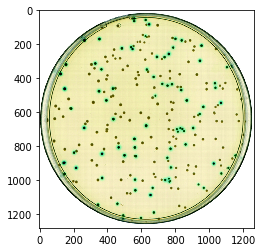

In [9]:
image = np.array(Image.open("img/colonies.jpg"))
plt.imshow(image)

### Construct a mask to remove the plate itself

In [10]:
center = np.array(image.shape[:2])/2
cutoff = 550
sq_cutoff = cutoff**2


mask = np.zeros(image.shape[:2],dtype=np.bool)
for i in range(image.shape[0]):
    d_i = (i - center[0])**2
    
    for j in range(image.shape[1]):
        d_j = (j - center[1])**2
        
        # If this pixel is too far away from center mask it
        if d_i + d_j > sq_cutoff:
            mask[i,j] = True

Creates a mask that is False if pixel is inside the plate and True if something is outside the plate.

### Apply mask

(Note cool different way to apply the mask).

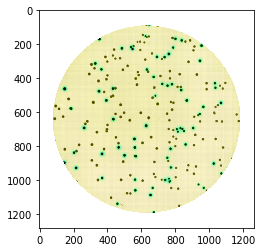

In [11]:
image[mask,:] = 255
#image[mask,1] = 255
#image[mask,2] = 255
plt.imshow(image)

### Now check out scikit-image

### Lay some ground work

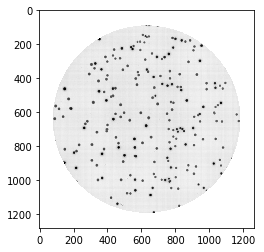

In [12]:
# Convert image to grayscale
image_gray = rgb2gray(image)
plt.imshow(image_gray,cmap="gray")


In [13]:
def plot_blobs(img,blobs):
    """
    Plot a set of blobs on an image.
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 

    ax.imshow(img, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax.add_patch(c)

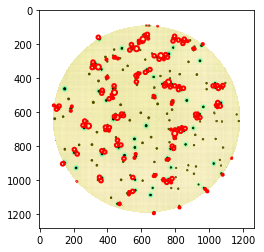

In [14]:
# blob_log
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
        
plot_blobs(image,blobs_log)

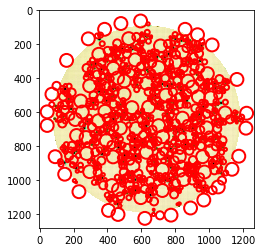

In [15]:
# blob_dog
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

plot_blobs(image,blobs_dog)

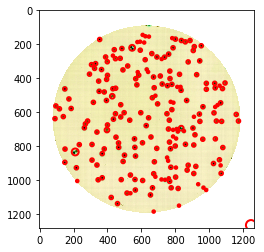

In [16]:
# blob_doh
blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)
plot_blobs(image,blobs_doh)

### Caveat LOG and DOG methods assume you are looking for bright spots.  We could improve by inverting image.  (but it was slow for demo)

### Get rid of big blobs

+ Write a function that gets rid of any blob with a radius bigger than 15.  Each blob is a tuple:
    
    ```blob1 = (y,x,r)```

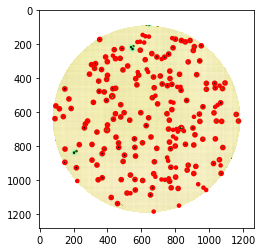

In [17]:
## KEY

def filter_blobs(blobs,r_cutoff=15):
    
    new_blobs = []
    for b in blobs:
        if b[2] < r_cutoff:
            new_blobs.append(b)
            
    return new_blobs

new_blobs = filter_blobs(blobs_doh)
plot_blobs(image,new_blobs)

### Now get the color of each blob

In [18]:
def get_blob_color(image,blob):

    # Grab circle center (a,b) and radius (r)
    a, b, r = blob
    
    # Grab total size of 
    nx, ny = image.shape[0:2]
    
    # Create a *circular* mask.  
    y,x = np.ogrid[-a:nx-a,-b:ny-b]
    mask = x*x + y*y <= r*r
    
    num_pixels = np.sum(mask)
    red = np.sum(image[mask,0])/num_pixels
    green = np.sum(image[mask,1])/num_pixels
    blue = np.sum(image[mask,2])/num_pixels
    
    return red, green, blue

In [19]:
blob_colors = []
for b in new_blobs:
    blob_colors.append(get_blob_color(image,b))

### Write a function that only takes a blob with an R channel less than 100


In [20]:
## KEY

num_not_red = 0
num_red = 0
for b in blob_colors:
    if b[0] < 100:
        num_not_red += 1
    else:
        num_red += 1
        
print("Num not red",num_not_red)
print("Num red",num_red)
        

Num not red 64
Num red 133


In [22]:
def plot_colored_results(img,blobs,colors):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 

    ax.imshow(img, interpolation='nearest')
    for i, blob in enumerate(blobs):
        y, x, r = blob
        
        if colors[i][0] < 100:
            color = "green"
        else:
            color = "gray"
        
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

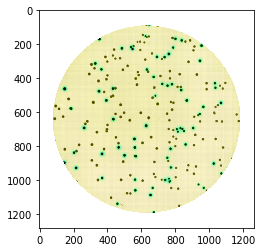

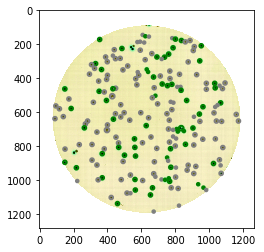

In [23]:
plt.imshow(image)
plot_colored_results(image,new_blobs,blob_colors)